## Preparations

Let us first load all the python libraries again

In [1]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import math
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
% matplotlib inline

from madminer.fisherinformation import FisherInformation
from madminer.fisherinformation import project_information,profile_information

from madminer.plotting import plot_fisher_information_contours_2d

from madminer.sampling import SampleAugmenter
from madminer.sampling import constant_benchmark_theta, multiple_benchmark_thetas
from madminer.sampling import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas
from madminer.ml import MLForge, EnsembleForge

from sklearn.metrics import mean_squared_error

## T2. Cross-Check: Validating score estimation

In [2]:
lhedatafile='data/madminer_lhedata.h5'
nsamples=10000

Let us now validate that the Machine Learning works. The central object consideres here is the score, so we will compare the truth level score with the estimated scores.  

### T2a) Run the Data Augmentation and Machine Learning part

First, we once again augment the dataand machine learning part again.

In [3]:
sa = SampleAugmenter(lhedatafile, debug=False)

x, theta, t_xz = sa.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'),
    n_samples=int(nsamples/2),
    folder='./data/samples_scores/',
    test_split=None,
    filename='train'
)

x, theta, t_xz = sa.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'),
    n_samples=int(nsamples/2),
    folder='./data/samples_scores/',
    test_split=None,
    filename='test',
    switch_train_test_events=True
)

Next, we use the perform the ML part, but with only one sample. We therefore use `MLForge` instead of `EnsembleForge`

In [4]:
forge = MLForge()
forge.train(
    method='sally',
    x_filename='./data/samples_scores/x_train.npy',
    t_xz0_filename='./data/samples_scores/t_xz_train.npy',
)
forge.save('models/samples_scores')

### T2b) Obtain scores

We can now obtain the scores. The truth scores have been stored during the augmentation step, and can simply be loaded. The ML scores can be evaluated.  

In [5]:
#True score
t_truth_train=np.load('./data/samples_scores/t_xz_train.npy')
t_truth_test=np.load('./data/samples_scores/t_xz_test.npy')

#ML score 
t_ml_train=forge.evaluate('./data/samples_scores/x_train.npy')
t_ml_test=forge.evaluate('./data/samples_scores/x_test.npy')

Let us now visualize the scores. The figure shows the 
- top:  score distribution
- center: the score correlation as 2D histogram
- bottom: the score correlation as scatter plot
Here we just present the 1st and 2nd component of the score. 

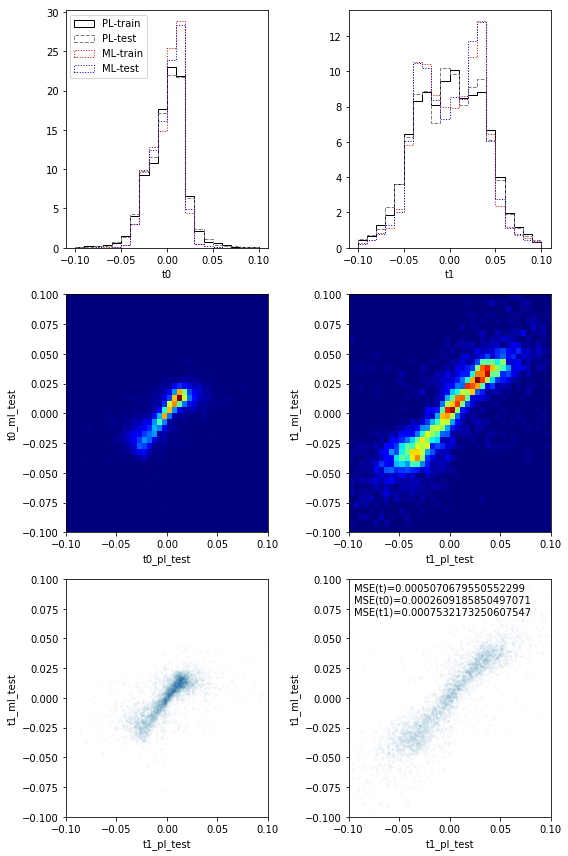

In [6]:
#######
#Figure
myrange=(-.1,.1)
myrangex=[-.1,.1]
f, ((ax11, ax12),(ax21, ax22),(ax31, ax32)) = plt.subplots(3, 2)
f.set_size_inches(8,12)

#######
#Distributions
mynbins=20

#t0
ax11.set_xlabel('t0')
ax11.hist(t_truth_train[:,0], 
         range=myrange, bins=mynbins, normed=True,
         histtype='step', color='Black', linestyle='solid', label='PL-train'
        )
ax11.hist(t_truth_test[:,0], 
         range=myrange, bins=mynbins, normed=True,
         histtype='step', color='Gray', linestyle='dashed', label='PL-test'
        )
ax11.hist(t_ml_train[:,0], 
         range=myrange, bins=mynbins, normed=True,
         histtype='step', color='Red', linestyle='dotted',label='ML-train'
        )
ax11.hist(t_ml_test[:,0], 
         range=myrange, bins=mynbins, normed=True,
         histtype='step', color='Blue', linestyle='dotted',label='ML-test'
        )
ax11.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)

#t1
ax12.set_xlabel('t1')
ax12.hist(t_truth_train[:,1], 
         range=myrange, bins=mynbins, normed=True,
         histtype='step', color='Black', linestyle='solid'
        )
ax12.hist(t_truth_test[:,1], 
         range=myrange, bins=mynbins, normed=True,
         histtype='step', color='Gray', linestyle='dashed', 
        )
ax12.hist(t_ml_train[:,1], 
         range=myrange, bins=mynbins, normed=True,
         histtype='step', color='Red', linestyle='dotted'
        )
ax12.hist(t_ml_test[:,1], 
         range=myrange, bins=mynbins, normed=True,
         histtype='step', color='Blue', linestyle='dotted'
        )

#######
#Density
ax21.hist2d(t_truth_test[:,0], t_ml_test[:,0], bins=(40, 40), range=(myrange,myrange) ,cmap='jet')
ax21.set_xlabel('t0_pl_test')
ax21.set_ylabel('t0_ml_test')

ax22.hist2d(t_truth_test[:,1], t_ml_test[:,1], bins=(40, 40), range=(myrange,myrange) ,cmap='jet')
ax22.set_xlabel('t1_pl_test')
ax22.set_ylabel('t1_ml_test')

#######
#MSE
mse_0 = mean_squared_error(t_truth_test[:,0],t_ml_test[:,0])
mse_1 = mean_squared_error(t_truth_test[:,1],t_ml_test[:,1])
mse_x = mean_squared_error(t_truth_test,t_ml_test)

#######
#Scatter
ax31.scatter(t_truth_test[:,0], t_ml_test[:,0],s=3,alpha=0.02)
ax31.set_xlabel('t1_pl_test')
ax31.set_ylabel('t1_ml_test')
ax31.set_xlim(myrangex)
ax31.set_ylim(myrangex)

ax32.scatter(t_truth_test[:,1], t_ml_test[:,1],s=3,alpha=0.02)
ax32.set_xlabel('t1_pl_test')
ax32.set_ylabel('t1_ml_test')
ax32.set_xlim(myrangex)
ax32.set_ylim(myrangex)
plt.text(myrange[0]+0.025*(myrange[1]-myrange[0]), myrange[0]+0.95*(myrange[1]-myrange[0]), 'MSE(t)='+str(mse_x), fontsize=10)
plt.text(myrange[0]+0.025*(myrange[1]-myrange[0]), myrange[0]+0.90*(myrange[1]-myrange[0]), 'MSE(t0)='+str(mse_0), fontsize=10)
plt.text(myrange[0]+0.025*(myrange[1]-myrange[0]), myrange[0]+0.85*(myrange[1]-myrange[0]), 'MSE(t1)='+str(mse_1), fontsize=10)

#######
#Plot
plt.tight_layout()
plt.show()

### T2c) Kinematic distribution of scores 

We can also look at kinematic distribution of scores

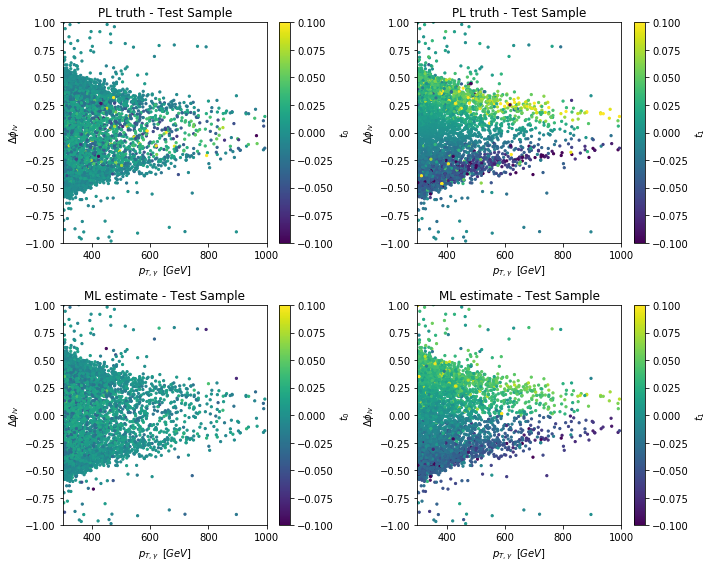

In [7]:
#Which pbservables to show

x_test=np.load('./data/samples_scores/x_test.npy')[:,14]
y_test=np.load('./data/samples_scores/x_test.npy')[:,18]
x_name='$p_{T,\gamma}\;\;[GeV]$'
y_name='$\Delta\phi_{lv}$'
x_range=[300,1000]
y_range=[-1,1]
v_range=[-.1,.1]
t_pl_test=np.load('./data/samples_scores/t_xz_test.npy')
t_ml_test=forge.evaluate('./data/samples_scores/x_test.npy')

#######
#Figure
marker_size=5
f, ((ax11, ax12),(ax21, ax22)) = plt.subplots(2, 2)
f.set_size_inches(10,8)

# t0 PL test
im11=ax11.scatter(x_test, y_test, marker_size, c=t_pl_test[:,0],vmin=v_range[0],vmax=v_range[1])
ax11.set_title("PL truth - Test Sample")
ax11.set_xlabel(x_name)
ax11.set_ylabel(y_name)
ax11.set_xlim(x_range)
ax11.set_ylim(y_range)
cb11=f.colorbar(im11, ax=ax11)
cb11.set_label("$t_0$")

# t1 PL test
im12=ax12.scatter(x_test, y_test, marker_size, c=t_pl_test[:,1],vmin=v_range[0],vmax=v_range[1])
ax12.set_title("PL truth - Test Sample")
ax12.set_xlabel(x_name)
ax12.set_ylabel(y_name)
ax12.set_xlim(x_range)
ax12.set_ylim(y_range)
cb12=f.colorbar(im12, ax=ax12)
cb12.set_label("$t_1$")

# t0 ML test
im21=ax21.scatter(x_test, y_test, marker_size, c=t_ml_test[:,0],vmin=v_range[0],vmax=v_range[1])
ax21.set_title("ML estimate - Test Sample")
ax21.set_xlabel(x_name)
ax21.set_ylabel(y_name)
ax21.set_xlim(x_range)
ax21.set_ylim(y_range)
cb21=f.colorbar(im21, ax=ax21)
cb21.set_label("$t_0$")

# t1 ML test
im22=ax22.scatter(x_test, y_test, marker_size, c=t_ml_test[:,1],vmin=v_range[0],vmax=v_range[1])
ax22.set_title("ML estimate - Test Sample")
ax22.set_xlabel(x_name)
ax22.set_ylabel(y_name)
ax22.set_xlim(x_range)
ax22.set_ylim(y_range)
cb22=f.colorbar(im22, ax=ax22)
cb22.set_label("$t_1$")

#######
#Plot
plt.tight_layout()
plt.show()